In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

## **Load in data**

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Botnet35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_BruteForce35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DDoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Portscan35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Benign35.csv')

In [ ]:
#ho salvato il file con 36 feature... la tolgo qui...
df = df.iloc[:, :-1]

In [ ]:
#pd.options.display.float_format = '{:,.20f}'.format

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


## **Define model architecture**

model architecture adapted from https://github.com/ydataai/ydata-synthetic - a model for generating credit card data

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline

import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras import Model

In [ ]:
!pip install sdv
%pip install sdmetrics
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.0/140.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.2 MB/s eta 0:00:00


In [ ]:
#FONTE: https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-loss-real')
    plt.plot(d2_hist, label='d-loss-fake')
    plt.plot(g_hist, label='g-loss')
    plt.legend()

    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()

    plt.show()



1.   Alpha (for LeakyReLU):
> * alpha is the slope of the negative part of the LeakyReLU activation function. It helps introduce a small, non-zero slope to the activation function for negative input values, preventing the neuron from being completely inactive.
> * A common value for alpha is in the range of 0.01 to 0.3. You can experiment with different values to see what works best for your specific dataset and model.

2.   Momentum (for Batch Normalization):
> * momentum is a parameter used in the update of the moving averages in batch normalization. It controls the contribution of the previous running mean and variance to the new estimates.
> * Common values for momentum are between 0.9 and 0.999. Higher values give more weight to the new batch, and lower values give more weight to the history.

3.   Dropout Rate (for Discriminator):
> * rate is the dropout rate, which represents the fraction of input units to drop during training.
> * A common value for rate is between 0.3 and 0.5. This means dropping 30% to 50% of the input units during training.





In [ ]:
alpha_leakyRelu = 0.01 #@param
momentumBN = 0.8 #@param
dropoutRate = 0.1 #@param

In [ ]:
#classe del modello intero GAN
class GAN():


    def __init__(self, gan_args):
        [self.batch_size, lr_d, lr_g, self.noise_dim,
         self.data_dim, layers_dim, beta] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        #Optimizers
        optimizer_discriminator = tf.keras.optimizers.Adam(lr_d, beta)
        optimizer_generator = tf.keras.optimizers.Adam(lr_g, beta)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_discriminator,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates samples
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model only the generator is trained
        self.discriminator.trainable = False

        # The discriminator takes generated samples as input and determines validity
        validity = self.discriminator(record)

        # The combined model
        # Trains the generator to try and create samples that will fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_generator)

    def get_data_batch(self, train, batch_size, seed=0):
        np.random.seed(3)
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def print_architecture(self):
      print("Generator Architecture:")
      self.generator.summary()
      print("\nDiscriminator Architecture:")
      self.discriminator.summary()
      print("\nCombined Model Architecture:")
      self.combined.summary()
      print("\n====================================================================================\n")


    def train(self, data, epochs):
        np.random.seed(3) # used for retestability
        tf.random.set_seed(3)
        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):
            # Discriminator
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new samples
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real, d_acc1 = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake, d_acc2 = self.discriminator.train_on_batch(gen_data, fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generator
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Therefore, using the loss values directly is not recommended in GANs.
            #Instead, metrics such as the Inception Score, Frechet Inception Distance (FID score),
            #and perceptual similarity measures (LPIPS) are used for interpreting the results.
            #PERFORMANCE
            d1_hist.append(d_loss_real)
            d2_hist.append(d_loss_fake)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            # Plot the progress
            print('==>> %d, dRLoss=%.3f, dFLoss=%.3f gLoss=%.3f, accR=%d, accF=%d' % (epoch, d_loss_real, d_loss_fake, g_loss, int(100*d_acc1), int(100*d_acc2)))
        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)




#DISCRIMINATORE
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4)(input) #512
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dropout(dropoutRate)(x)
        x = Dense(dim * 2)(x) #256
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dropout(dropoutRate)(x)
        x = Dense(dim)(x) #128
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)


#Generatore
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim)(input_layer) #dim=128
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 2)(x) #256
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        x = Dense(dim * 4)(x) #512
        x = LeakyReLU(alpha=alpha_leakyRelu)(x)
        x = BatchNormalization(momentum=momentumBN)(x)
        output_layer = Dense(data_dim, activation='sigmoid')(x) # Use sigmoid activation in the output layer to constrain values to [0, 1]
        return Model(inputs=input_layer, outputs=output_layer)


## Training & Generazione

**Generating class data**

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```




```
Given that your original data has 35 features
--> you might want to experiment with sizes around 35 or slightly larger <--
to ensure that the input noise vector captures additional variations while respecting the underlying structure of the data
```



Choosing extremely low values might cause the optimizer to behave in a way that resembles simpler optimization algorithms, possibly leading to slower convergence or even convergence to suboptimal solutions. The default values for ***beta1*** and ***beta2*** (0.9 and 0.999, respectively) are chosen to strike a balance between adapting to recent information and maintaining stability during training.

In [ ]:
data_columns = df.columns

#generator & discriminator parameters
batch_size = 1024 #@param
lr_d=0.0001 #@param
lr_g=0.0003 #@param
#common ranges for beta1 (0.8 to 0.99) and beta2 (0.9 to 0.999) ==> era 0.5
beta=0.5  #@param
input_noise = 16  #@param

input_shape=35 #numeroFeatures
dim=128 #@param


#training parameters
epochs = 6000 #@param

In [ ]:
generator_parameters = [batch_size, lr_d, lr_g, input_noise, input_shape, dim, beta]

## Training

In [ ]:
gan = GAN(generator_parameters)

In [ ]:
#gan.print_architecture()

Output streaming troncato alle ultime 5000 righe.
32/32 [==============================] - 0s 1ms/step
==>> 3500, dRLoss=0.692, dFLoss=0.669 gLoss=0.759, accR=55, accF=59
32/32 [==============================] - 0s 1ms/step
==>> 3501, dRLoss=0.687, dFLoss=0.695 gLoss=0.736, accR=56, accF=46
32/32 [==============================] - 0s 1ms/step
==>> 3502, dRLoss=0.686, dFLoss=0.677 gLoss=0.761, accR=60, accF=58
32/32 [==============================] - 0s 1ms/step
==>> 3503, dRLoss=0.687, dFLoss=0.682 gLoss=0.757, accR=58, accF=57
32/32 [==============================] - 0s 1ms/step
==>> 3504, dRLoss=0.687, dFLoss=0.696 gLoss=0.747, accR=57, accF=50
32/32 [==============================] - 0s 1ms/step
==>> 3505, dRLoss=0.681, dFLoss=0.697 gLoss=0.736, accR=61, accF=48
32/32 [==============================] - 0s 1ms/step
==>> 3506, dRLoss=0.686, dFLoss=0.695 gLoss=0.751, accR=61, accF=48
32/32 [==============================] - 0s 1ms/step
==>> 3507, dRLoss=0.688, dFLoss=0.661 gLoss=0.777,

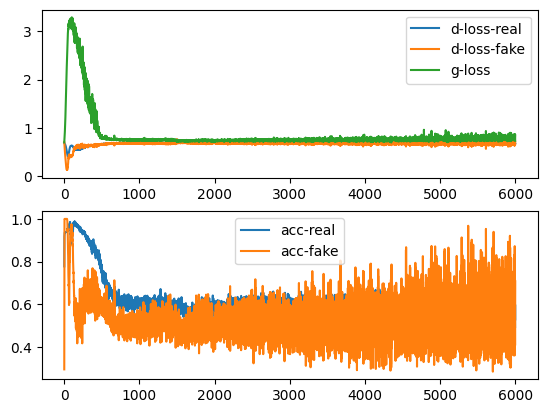

In [ ]:
gan.train(df, epochs)

In [ ]:
models = {'GAN': ['GAN', False, gan.generator]}



```
By setting a seed, you can ensure that the randomness introduced
by the use of random number generators is consistent across different runs of your code,
which can help make your results more reliable and reproducible
```



In [ ]:
np.random.seed(3) # used for retestability

num_rows_gen = 1000 #quante righe verranno generate
noise = np.random.normal(0, 1, (num_rows_gen, input_noise))

[model_name, with_class, generator_model] = models['GAN']

X = generator_model.predict(noise)

32/32 [==============================] - 0s 2ms/step


In [ ]:
# Create a dataframe with generated samples, so can be used for evaluation later
gen_samples = pd.DataFrame(X, columns=data_columns)

#### Salvo csv

In [ ]:
#SALVO CSV data gen
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBotnet.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBruteforce.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genDDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genPortscan.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo2/genBenign.csv', index = False)

#### Preparo x valutazione Quant&Qualit

In [ ]:
print(df.shape)
print(gen_samples.shape)

(515, 35)
(1000, 35)


In [ ]:
df.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.000697,0.003369,0.123304,0.005698,0.000595,0.350332,0.591888,0.006554,0.000207,0.0,...,0.000024,0.019501,0.000639,0.000210,0.505989,0.0,0.510604,0.000697,0.454545,0.125002
1,0.000743,0.009530,0.123304,0.000015,0.000720,0.000243,0.015588,0.006554,0.000034,0.0,...,0.000161,0.003616,0.000730,0.000523,0.501406,0.0,0.502048,0.000743,0.454545,0.125002
2,0.000544,0.009530,0.123304,0.000079,0.000523,0.005197,0.072089,0.006554,0.000046,0.0,...,0.000118,0.003738,0.000533,0.000382,0.501406,0.0,0.502048,0.000544,0.454545,0.125002
3,0.001772,0.008476,0.123304,0.000015,0.001747,0.000202,0.014202,0.006554,0.000017,0.0,...,0.000308,0.003616,0.001752,0.001126,0.501711,0.0,0.502353,0.001772,0.454545,0.125002
4,0.001473,0.002364,0.123304,0.011399,0.001283,0.541907,0.736143,0.006554,0.000179,0.0,...,0.000027,0.019150,0.001399,0.000374,0.509044,0.0,0.520689,0.001473,0.454545,0.125002


In [ ]:
gen_samples.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.000822,0.009486,0.123632,0.000033,0.000739,0.000346,0.015767,0.006628,7.768643e-05,5.204137e-07,...,1.979936e-04,0.003359,0.000981,0.000573,0.500608,6.722838e-07,0.500255,0.000959,0.455715,0.125768
1,0.000716,0.009366,0.123385,0.000021,0.000592,0.000413,0.015366,0.006738,1.422820e-05,1.319075e-07,...,9.311139e-05,0.003346,0.000597,0.000390,0.502130,1.619900e-07,0.500096,0.000456,0.456466,0.126114
2,0.000174,0.001544,0.090364,0.004901,0.004640,0.899459,0.965560,0.011917,4.084235e-16,7.374731e-09,...,1.632225e-16,0.026085,0.000471,0.000052,0.561499,8.785788e-08,0.565459,0.001131,0.447869,0.104523
3,0.000770,0.009002,0.123672,0.000029,0.000808,0.000398,0.015833,0.006360,9.365396e-05,6.458672e-07,...,1.754330e-04,0.003321,0.001004,0.000811,0.501151,9.159630e-07,0.500809,0.000737,0.455943,0.126078
4,0.000942,0.009443,0.123945,0.000035,0.000821,0.000377,0.015924,0.006488,9.216863e-05,6.973759e-07,...,2.027378e-04,0.003391,0.001002,0.000711,0.501479,9.602699e-07,0.500412,0.001111,0.456733,0.125618


#Valutazione

Text(0.5, 1.0, 'Dati generati')

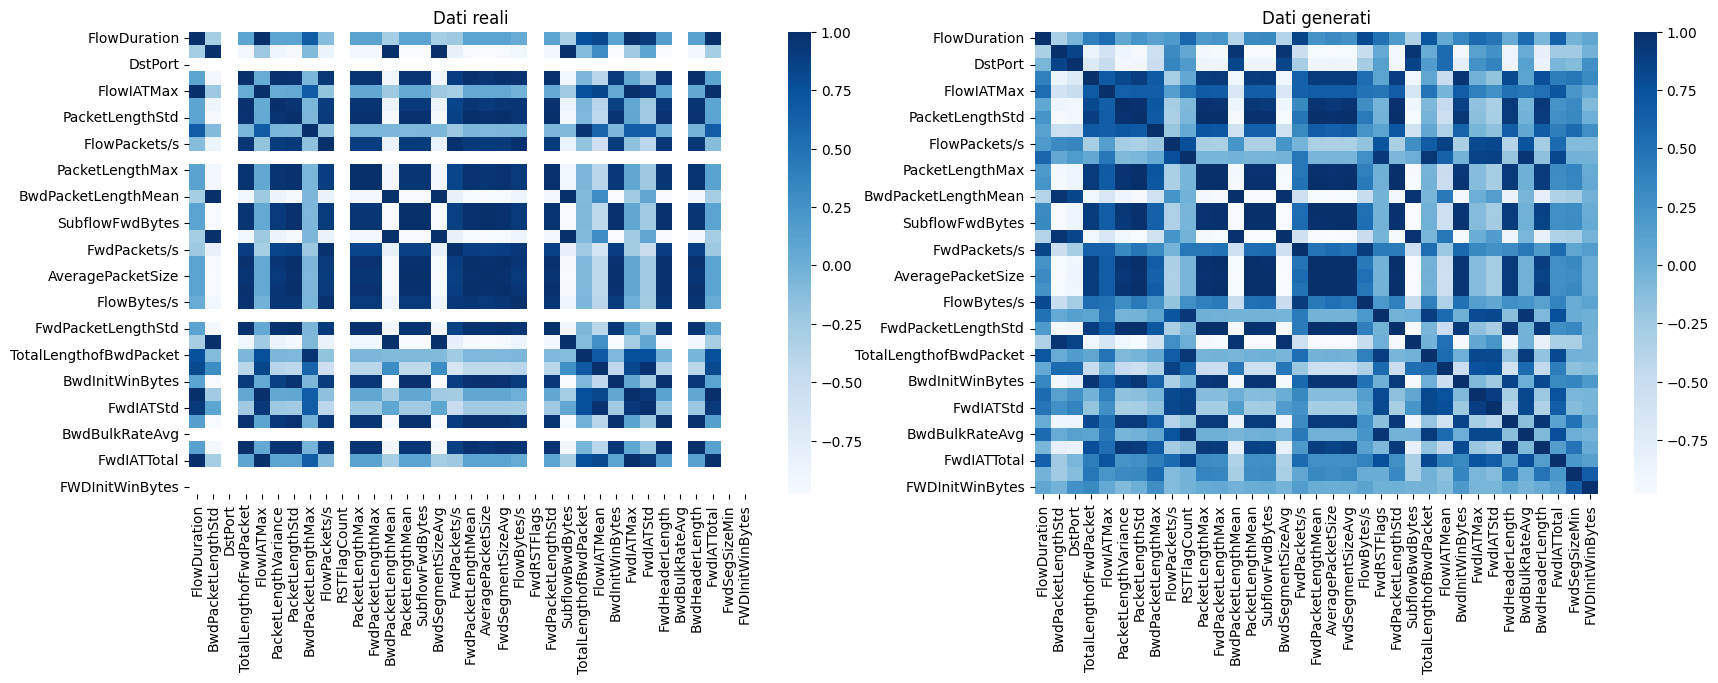

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(df.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_samples.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Dati reali")
ax[1].set_title("Dati generati")

In [ ]:
real_data = df.to_numpy()
generated_data = gen_samples.to_numpy()

In [ ]:
from scipy.stats import wasserstein_distance

# Flatten the arrays for 1D distribution
real_flat = real_data.flatten()
generated_flat = generated_data.flatten()

# Compute Wasserstein distance
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance delle distribuzioni:', w_distance)

Wasserstein Distance delle distribuzioni: 0.003074544031738145




```
Interpretation can depend on the scale and nature of your data, but in general:
## Closer to 0: Indicates a smaller difference between distributions.
```



In [ ]:
real = df['FlowDuration'].to_numpy()
gen = gen_samples['FlowDuration'].to_numpy()

w_dist_feature = wasserstein_distance(real, gen)
print("Wasserstein Distance per la feature FlowDuration:", w_dist_feature)

Wasserstein Distance per la feature FlowDuration: 0.0003042873976914402


In [ ]:
from sdmetrics.single_column import KSComplement

KSComplement.compute(
    real_data=df['FlowDuration'],
    synthetic_data=gen_samples['FlowDuration']
)

#voglio più vicino a 1

0.48516504854368936

In [ ]:
from sdmetrics.single_column import StatisticSimilarity

StatisticSimilarity.compute(
    real_data=df['FlowDuration'],
    synthetic_data=gen_samples['FlowDuration'],
    statistic='mean'
)

#voglio più vicino a 1

0.9879797617520276

In [ ]:
# Choose the column you want to check
# 0 = FlowDuration
# 1 = BwdPacketLengthStd
# 2 = DstPort
# 3 = TotalLenghtofFwdPacket
# 4 = FlowIATMax
# 5 = PacketLengthVariance

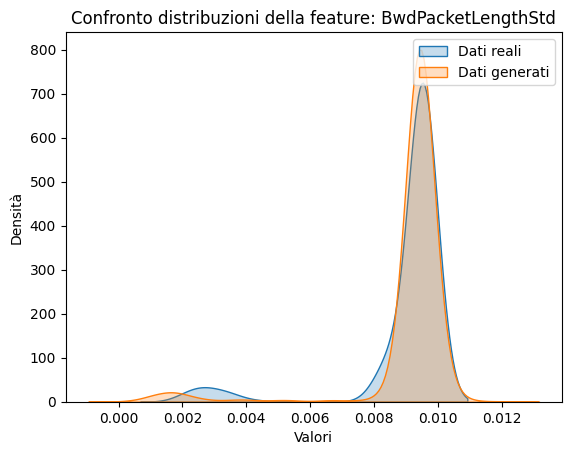

In [ ]:
column_to_compare = 1
# Extract the selected column for each array
real_column = real_data[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {df.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend()
#salva in Drive
#images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
#plt.savefig(f"{images_dir}/distributionFeatureFlowDuration_genGAN_t2.pdf", dpi=200, format='pdf') ###!!!!!!!!!!!!!! CAMBIARE TENTATIVI CON N°
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

real_data_first_column = real_data[:, 0]
gen_data_first_column = generated_data[:, 0]

# Downsample gen_data_first_column to match the size of real_data_first_column - 736
downsampled_gen_data_first_column = np.random.choice(gen_data_first_column, size=(len(real_data_first_column),), replace=True) #False

# Calculate the Mean Squared Error
mse = mean_squared_error(real_data_first_column, downsampled_gen_data_first_column)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.695950042616615e-07




```
Interpretation:

*   A smaller MSE indicates that the generated data is closer to the real data in terms of the selected feature.
*  Closer to 0 suggests better performance for that specific feature.


```



#Vecchi metodi valutazione
*   https://github.com/sdv-dev/SDV
*   https://docs.sdv.dev/sdv



In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [ ]:
quality_report = evaluate_quality(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:58<00:00, 10.13it/s]

Overall Score: 55.1%

Properties:
- Column Shapes: 40.36%
- Column Pair Trends: 69.85%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 341.33it/s]

Overall Score: 81.26%

Properties:
- Data Validity: 62.52%
- Data Structure: 100.0%
